# Load in Data

In [1]:
import pandas as pd
import numpy as np

# Import outcomes dataset
places_500_cities = pd.read_csv("Data/500_Cities__Local_Data_for_Better_Health__2019_release_20240314.zip", dtype={'TractFIPS': str})

# Keep census tract level samples only
ct_500_cities = places_500_cities[places_500_cities['GeographicLevel'] == 'Census Tract']

# Drop columns not useful
columns_to_remove = ['StateDesc', 'CityName', 'GeographicLevel', 'DataSource', 'Category', 'UniqueID', 'Measure', 'Data_Value_Unit', 'DataValueTypeID', 'Data_Value_Type', 'Low_Confidence_Limit', 'High_Confidence_Limit', 'Data_Value_Footnote_Symbol', 'Data_Value_Footnote', 'PopulationCount', 'GeoLocation', 'CategoryID', 'Short_Question_Text']
ct_500_cities = ct_500_cities.drop(columns=columns_to_remove)

## These are positive measurements, while the rest in the data are negative. We want high percentages to be bad. So for positive, I am taking the complement.
ct_500_cities.loc[ct_500_cities['MeasureId'].isin(['DENTAL', 'COLON_SCREEN', 'COREW', 'COREM', 'BPMED', 'CHOLSCREEN', 'CHECKUP', 'PAPTEST', 'MAMMOUSE']), 'Data_Value'] = 100 - ct_500_cities.loc[ct_500_cities['MeasureId'].isin(['DENTAL', 'COLON_SCREEN', 'COREW', 'BPMED', 'CHOLSCREEN', 'CHECKUP', 'PAPTEST', 'MAMMOUSE']), 'Data_Value']
ct_500_cities.head()

,Year,StateAbbr,Data_Value,MeasureId,CityFIPS,TractFIPS
0,2017,CA,14.6,ARTHRITIS,632548.0,06037602504
5,2017,CA,22.0,ARTHRITIS,636448.0,06065045213
8,2017,CA,12.7,DIABETES,636546.0,06037601801
15,2016,AL,18.1,MAMMOUSE,135896.0,01073014302
18,2017,AL,9.3,DIABETES,137000.0,01089002922


In [2]:

# HPSAs could sometimes be county-wide or county subdivisions. This data will work as a crosswalk to get the census tracts within those areas.
csd_to_ct_2010 = pd.read_csv("Data/CSD_to_CT_2010.csv", dtype=str)
# Format fields for join with census tracts in the other datasets.
csd_to_ct_2010['csd'] = csd_to_ct_2010['county'] + csd_to_ct_2010['cousubfp']
csd_to_ct_2010['tract'] = csd_to_ct_2010['tract'].apply(lambda x: x + '00' if '.' not in x else x)
csd_to_ct_2010['ct'] = csd_to_ct_2010['county'] + csd_to_ct_2010['tract'].str.replace(".", "")

# Health Professional Shortage Areas - Primary Care & Dental Health
hpsa_pc_full = pd.read_csv("Data\BCD_HPSA_FCT_DET_PC.csv")
hpsa_dh_full = pd.read_csv("Data\BCD_HPSA_FCT_DET_DH.csv")
hpsa_pc_dh_full = pd.merge(hpsa_pc_full, hpsa_dh_full, how='outer')

# Data files shows historical dates of when an area has a change in HPSA status.
# Picking all areas that were listed as an HSPA on 12/31/2017 to avoid duplications.
hpsa_pc_dh = hpsa_pc_dh_full[(pd.to_datetime(hpsa_pc_dh_full['HPSA Designation Date']) <= '2017-12-31')]
hpsa_pc_dh = hpsa_pc_dh[(pd.to_datetime(hpsa_pc_dh['Withdrawn Date']) > '2017-12-31') | hpsa_pc_dh['Withdrawn Date'].isna()]

# Not specific locations (eg correctional facilities)
hpsa_pc_dh = hpsa_pc_dh[hpsa_pc_dh['HPSA Geography Identification Number'] != 'POINT']

# Only when everybody in a specifc area has a shortage, not specific populations within an area (eg migrant workers)
hpsa_pc_dh = hpsa_pc_dh[hpsa_pc_dh['Designation Type'] == 'Geographic HPSA'] 

# Remove columns - some might be useful but will want to get the demographic info from another source that has the info for all census tracts.
hpsa_pc_dh = hpsa_pc_dh.loc[:, ['HPSA Discipline Class', 'HPSA Score', 'PC MCTA Score', 'HPSA Geography Identification Number', 'HPSA Component Type Code', 'HPSA Designation Date']]

# Sorting data by designation date. If there are duplicates, keeping the older record
hpsa_pc_dh = hpsa_pc_dh.sort_values(by='HPSA Designation Date')
hpsa_pc_dh = hpsa_pc_dh.drop_duplicates(subset='HPSA Geography Identification Number', keep='first')

# Creating the specific columns for primary care and dental health
hpsa_pc_dh['PC_HPSA_Score'] = np.where(hpsa_pc_dh['HPSA Discipline Class'] == 'Primary Care', hpsa_pc_dh['HPSA Score'], np.nan)
hpsa_pc_dh['DH_HPSA_Score'] = np.where(hpsa_pc_dh['HPSA Discipline Class'] == 'Dental Health', hpsa_pc_dh['HPSA Score'], np.nan)

# Remove columns that aren't needed anymore
hpsa_pc_dh = hpsa_pc_dh.drop(columns=['HPSA Designation Date', 'HPSA Score', 'HPSA Discipline Class'])

# (1) Load ACS data (2) Drop the column with the row index (3) For all features, convert non-numeric values to NaN values
acs_dp05 = pd.read_csv("Data\ACSDP5Y2017.DP05-Data_CLEAN.csv", dtype={"Geography": str})
# Remove duplicate column
acs_dp05 = acs_dp05.drop(columns=['Unnamed: 0', 'Percent Estimate!!RACE!!Total population!!One race.1'])

for column in acs_dp05.columns:
  if column != 'Geography':
    acs_dp05[column] = pd.to_numeric(acs_dp05[column], errors='coerce')

acs_s1810 = pd.read_csv("Data\ACSDP5Y2017.S1810-Data_CLEAN.csv", dtype={"Geography": str})

for column in acs_s1810.columns:
  if column.startswith('Estimate!!Percent'):
      acs_s1810[column] = pd.to_numeric(acs_s1810[column], errors='coerce')

acs_s1810 = acs_s1810.drop(columns='Unnamed: 0')

acs_dp03 = pd.read_csv("Data\ACSDP5Y2017.DP03-Data_CLEAN.csv", dtype={"Geography": str})
acs_dp03 = acs_dp03.drop(columns=['Unnamed: 0'])

for column in acs_dp03.columns:
  if column != 'Geography':
    acs_dp03[column] = pd.to_numeric(acs_dp03[column], errors='coerce')

acs_dp02 = pd.read_csv("Data\ACSDP5Y2017.DP02-Data_CLEAN.csv", dtype={"Geography": str})
acs_dp02 = acs_dp02.drop(columns=['Unnamed: 0'])
# Getting disability info from another dataset
acs_dp02 = acs_dp02.drop(columns=[col for col in acs_dp02.columns if col.startswith('Percent Estimate!!DISABILITY STATUS OF THE CIVILIAN NONINSTITUTIONALIZED POPULATION!!')]) 

for column in acs_dp02.columns:
  if column != 'Geography':
    acs_dp02[column] = pd.to_numeric(acs_dp02[column], errors='coerce')

# For fields without a complement, add a complement
acs_dp02['Percent Estimate!!COMPUTERS AND INTERNET USE!!Total households!!Without a computer'] = 100 - acs_dp02['Percent Estimate!!COMPUTERS AND INTERNET USE!!Total households!!With a computer']
acs_dp02['Percent Estimate!!COMPUTERS AND INTERNET USE!!Total households!!Without a broadband Internet subscription'] = 100 - acs_dp02['Percent Estimate!!COMPUTERS AND INTERNET USE!!Total households!!With a broadband Internet subscription'] # Adding complement
acs_dp02["Percent Estimate!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Percent less than bachelor's degree"] = 100 - acs_dp02["Percent Estimate!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Percent bachelor's degree or higher"] # Adding complement
acs_dp02["Percent Estimate!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Percent less than high school graduate"] = 100 - acs_dp02["Percent Estimate!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Percent high school graduate or higher"] # Adding complement

acs_dp04 = pd.read_csv("Data\ACSDP5Y2017.DP04-Data_CLEAN.csv", dtype={"Geography": str})
acs_dp04 = acs_dp04.drop(columns=['Unnamed: 0'])

for column in acs_dp04.columns:
  if column != 'Geography':
    acs_dp04[column] = pd.to_numeric(acs_dp04[column], errors='coerce')


# Separate HPSA information based on how the geographic area is defined (counties/county subdivisions/census tracts)
hpsa_cty = hpsa_pc_dh[hpsa_pc_dh['HPSA Component Type Code'] == 'SCTY'].drop(columns=['HPSA Component Type Code'])
hpsa_csd = hpsa_pc_dh[hpsa_pc_dh['HPSA Component Type Code'] == 'CSD'].drop(columns=['HPSA Component Type Code'])
hpsa_ct = hpsa_pc_dh[hpsa_pc_dh['HPSA Component Type Code'] == 'CT'].drop(columns=['HPSA Component Type Code'])

# For HPSA defined by county subdivisions, merge with county subdivision to census tract crosswalk
hpsa_csd_with_ct = hpsa_csd.merge(csd_to_ct_2010, left_on='HPSA Geography Identification Number', right_on='csd', how='inner')
hpsa_ct_copy = hpsa_ct[['HPSA Geography Identification Number']].rename(columns={'HPSA Geography Identification Number': 'HPSA Geography Identification Number_ct'})
merge_csd_ct = hpsa_csd_with_ct.merge(hpsa_ct_copy, left_on='ct', right_on='HPSA Geography Identification Number_ct', how='left', indicator=True)

# Drop records where the crosswalked census tract is already in the census tract dataframe
merge_csd_ct = merge_csd_ct[(merge_csd_ct['_merge'] != 'both')]
# Update 'HPSA Geography Identification Number' to CT
merge_csd_ct['HPSA Geography Identification Number'] = merge_csd_ct['ct']

# Remove columns that aren't needed
merge_csd_ct.drop(columns=['county', 'csd', 'ct', 'HPSA Geography Identification Number_ct', '_merge'], inplace=True)

# When the census tract is duplicated, take the mean of the scores.
merge_csd_ct_uniques = merge_csd_ct.drop_duplicates(subset='HPSA Geography Identification Number', keep=False, ignore_index=True)
merge_csd_ct_duplicates = merge_csd_ct[merge_csd_ct.duplicated(subset='HPSA Geography Identification Number', keep=False)].groupby(['HPSA Geography Identification Number']).agg({'PC_HPSA_Score': 'mean', 'DH_HPSA_Score': 'mean', 'PC MCTA Score': 'mean'})
merge_csd_ct_duplicates.reset_index(inplace=True)
merge_csd_ct = pd.concat([merge_csd_ct_uniques, merge_csd_ct_duplicates], ignore_index=True)

# For HPSA defined by county subdivisions, merge with county subdivision to census tract crosswalk
hpsa_cty_with_ct = hpsa_cty.merge(csd_to_ct_2010, left_on='HPSA Geography Identification Number', right_on='county', how='inner')
merge_csd_ct_copy = merge_csd_ct[['HPSA Geography Identification Number']].rename(columns={'HPSA Geography Identification Number': 'HPSA Geography Identification Number_ct'})
merge_cty_ct = hpsa_cty_with_ct.merge(merge_csd_ct_copy, left_on='ct', right_on='HPSA Geography Identification Number_ct', how='left', indicator=True)

# Drop records where the crosswalked census tract is already in the census tract dataframe
merge_cty_ct = merge_cty_ct[(merge_cty_ct['_merge'] != 'both')]
# Update 'HPSA Geography Identification Number' to census tract
merge_cty_ct['HPSA Geography Identification Number'] = merge_cty_ct['ct']

# Remove columns that aren't needed
merge_cty_ct.drop(columns=['county', 'csd', 'ct', 'HPSA Geography Identification Number_ct', '_merge'], inplace=True)

# When the census tract is duplicated, take the mean of the scores.
merge_cty_ct_uniques = merge_cty_ct.drop_duplicates(subset='HPSA Geography Identification Number', keep=False, ignore_index=True)
merge_cty_ct_duplicates = merge_cty_ct[merge_cty_ct.duplicated(subset='HPSA Geography Identification Number', keep=False)].groupby(['HPSA Geography Identification Number']).agg({'PC_HPSA_Score': 'mean', 'DH_HPSA_Score': 'mean', 'PC MCTA Score': 'mean'}) # When the CT is duplicated, take the mean of the other scores.
merge_cty_ct_duplicates.reset_index(inplace=True)
merge_cty_ct = pd.concat([merge_cty_ct_uniques, merge_cty_ct_duplicates], ignore_index=True)


merge_all_hpsa = pd.concat([hpsa_ct, merge_csd_ct, merge_cty_ct])
# merge_all_hpsa['HPSA Geography Identification Number'] = merge_all_hpsa['HPSA Geography Identification Number']

# Merge all data together by census tract
merge_all_data = pd.merge(ct_500_cities.loc[:, ['MeasureId', 'TractFIPS', 'Data_Value']], merge_all_hpsa, left_on=['TractFIPS'], right_on=['HPSA Geography Identification Number'], how='left')
merge_all_data = pd.merge(merge_all_data, acs_dp05, left_on=['TractFIPS'], right_on=['Geography'], how='left')
merge_all_data = pd.merge(merge_all_data, acs_s1810, left_on=['TractFIPS'], right_on=['Geography'], how='left')
merge_all_data = pd.merge(merge_all_data, acs_dp04, left_on=['TractFIPS'], right_on=['Geography'], how='left')
merge_all_data = pd.merge(merge_all_data, acs_dp03, left_on=['TractFIPS'], right_on=['Geography'], how='left')
merge_all_data = pd.merge(merge_all_data, acs_dp02, left_on=['TractFIPS'], right_on=['Geography'], how='left')
merge_all_data[['PC_HPSA_Score', 'DH_HPSA_Score', 'PC MCTA Score']] = merge_all_data[['PC_HPSA_Score', 'DH_HPSA_Score', 'PC MCTA Score']].fillna(0) # If NaN, these scores weren't on files. This means they aren't considered an HPSA. So a score of 0.

# Drop columns that aren't needed anymore
merge_all_data = merge_all_data.drop(columns=['TractFIPS', 'HPSA Geography Identification Number', 'cousubfp', 'tract', 'Geography_x', 'Geography_y'])

In [3]:
print(len(merge_all_data.columns))

# columns_to_remove = [col for col in merge_all_data.columns if col.endswith('s')]
# columns_to_remove = columns_to_remove + [col for col in merge_all_data.columns if col.endswith('y')]
# columns_to_remove = columns_to_remove + [col for col in merge_all_data.columns if col.endswith('r')]
# columns_to_remove = columns_to_remove + [col for col in merge_all_data.columns if col.endswith('t')]
# columns_to_remove = columns_to_remove + [col for col in merge_all_data.columns if col.endswith('0')]
# columns_to_remove = columns_to_remove + [col for col in merge_all_data.columns if col.endswith('9')]
# columns_to_remove = columns_to_remove + [col for col in merge_all_data.columns if col.endswith('e') and col != 'Data_Value']

ARTH_TRAIN = merge_all_data#.drop(columns=columns_to_remove)                                     

print(len(ARTH_TRAIN.columns))

483
483


In [13]:
corr_matrix = ARTH_TRAIN.corr()

In [14]:
upper_triangle = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
upper_triangle = corr_matrix.where(upper_triangle)
upper_triangle.to_csv('upper_correlation_matrix.csv', index=True, header=True)
corr_matrix.to_csv('correlation_matrix.csv', index=True, header=True)


# Ensemble Method

In [6]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier as ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import classification_report
import shap

measure_id_set = set(ct_500_cities['MeasureId']) - {'MAMMOUSE', 'PAPTEST', 'BINGE', 'HIGHCHOL', 'COREM', 'BPHIGH', 'CHOLSCREEN', 'BPMED', 'CASTHMA', 'COREW', 'ARTHRITIS', 'PHLTH'} - {'DENTAL', 'TEETHLOST', 'MHLTH', 'CHD', 'CHECKUP', 'CSMOKING', 'DIABETES', 'SLEEP', 'CANCER'}

for measure in measure_id_set:

  # Get data for only the selected measure, and drop any census tracts where there is a NaN Data_Value for that meausre.
  merge_data_measure = ARTH_TRAIN[merge_all_data['MeasureId'] == measure].dropna(subset=['Data_Value'])
  merge_data_measure = merge_data_measure.reset_index(drop=True)
  scaler = StandardScaler()

  y = merge_data_measure['Data_Value']

  least_important = ['start']
  test_scores = [1]
  feature_count = len(ARTH_TRAIN.columns) - 1
  
  if measure == 'ACCESS2': # Remove health insurance coverage features since that is what we're predicting with the measure
     merge_data_measure = merge_data_measure.drop(columns=['Percent Estimate!!HEALTH INSURANCE COVERAGE!!Civilian noninstitutionalized population!!No health insurance coverage', 'Percent Estimate!!HEALTH INSURANCE COVERAGE!!Civilian noninstitutionalized population!!Civilian noninstitutionalized population 19 to 64 years!!Not in labor force!!No health insurance coverage',
                                                           'Percent Estimate!!HEALTH INSURANCE COVERAGE!!Civilian noninstitutionalized population!!Civilian noninstitutionalized population 19 to 64 years!!In labor force!!Unemployed!!No health insurance coverage', 'Percent Estimate!!HEALTH INSURANCE COVERAGE!!Civilian noninstitutionalized population!!Civilian noninstitutionalized population under 19 years!!No health insurance coverage'])

  print(f"\n\nBegin Outcome: {measure}")

  # while len(least_important) >= 1 and ((feature_count - len(least_important)) >= 10 or np.mean(test_scores) > 0.7):
  while feature_count > 10 and np.mean(test_scores) > 0.75:
    print(f"Outcome: {measure}")

    # Recursive Feature Elimination - Drop the features that were the least important from the previous iteration
    if least_important[0] != 'start':
      merge_data_measure = merge_data_measure.drop(columns=least_important)
    
    

    # Commenting this out since Gina doesn't need it right now.
    # print("Updating FIPS codes to retain State and County Level only. This should take about ~3 minutes.")
    # merge_data_measure['FIPS'] = merge_data_measure['FIPS'].values.astype(str)
    # for row in merge_data_measure['FIPS']:
    #   merge_data_measure.replace(row, row[:5], inplace = True)
    # FIPS = merge_data_measure['FIPS'].copy()
    # print("FIPS Update complete.")

    # Keep only the numeric features. Drop data_value column since that will be the predicted variable.
    X_numeric = merge_data_measure.select_dtypes(include='number').drop(columns=['Data_Value'])
    # Scale the features
    X_numeric_scaled = scaler.fit_transform(X_numeric)

    # Create 3 bins for the outcomes data. All 3 will be of equal size. The cutoff for each quantile is different for each measure.
    y_binned = pd.qcut(y, q=3, labels=False)

    feature_count = len(X_numeric.columns)
    print("new feature_count", feature_count)

    N_SPLITS = 10
    SKF = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)

    SKF.get_n_splits(X = X_numeric_scaled, y = y_binned)

    # Instructor says max depth 1-5 for random forests
    # StatQuest says max_leaf_nodes is usually 8-32
    # parameters = {'class_weight': [None], 'early_stopping': ['auto'], 'interaction_cst': [None], 'l2_regularization': [0.0], 'learning_rate': [0.1],
    #               'loss': ['log_loss'],'max_bins': [10, 20, 100], 'max_depth': [5], 'max_iter': [25, 50, 100], 'max_leaf_nodes': [8, 16, 32],
    #               'min_samples_leaf': [10, 100, 500], 'monotonic_cst': [None], 'n_iter_no_change': [10], 'random_state': [None], 'scoring': ['loss'],
    #               'tol': [1e-07], 'validation_fraction': [0.1], 'verbose': [0], 'warm_start': [False]}
    parameters = {'class_weight': [None], 'early_stopping': ['auto'], 'interaction_cst': [None], 'l2_regularization': [0.0], 'learning_rate': [0.1], 'loss': ['log_loss'],'max_bins': [10],
                  'max_depth': [5], 'max_iter': [50], 'max_leaf_nodes': [16], 'min_samples_leaf': [100], 'monotonic_cst': [None], 'n_iter_no_change': [10], 'random_state': [None],
                  'scoring': ['loss'], 'tol': [1e-07], 'validation_fraction': [0.1], 'verbose': [0], 'warm_start': [False]}

    param_combo_scores = {}
    param_combo_times = {}
    test_scores = []
    train_scores = []
    feature_importances_all = []

    scoring = 'accuracy'

    # Initiate a Ensemble classifier
    clf = ensemble()

    current_best = 0
    print("Beginning Model Training\n\n")

    for index, (train_index, test_index) in enumerate(SKF.split(X = X_numeric_scaled, y = y_binned)):
        x_train = np.take(X_numeric_scaled, train_index, 0)
        y_train = np.take(y_binned, train_index, 0)

        x_test = np.take(X_numeric_scaled, test_index, 0)
        y_test = np.take(y_binned, test_index, 0)

        grid = GridSearchCV(clf, param_grid = parameters, scoring = scoring)
        grid.fit(X = x_train, y = y_train)
        best_estimator = grid.best_estimator_
        test_score = grid.score(X = x_test, y = y_test)

        feature_importances_all.append(permutation_importance(grid.best_estimator_, x_test, y_test))
        y_pred = best_estimator.predict(x_test)

        for params, score, time in zip(grid.cv_results_['params'], grid.cv_results_['mean_test_score'], grid.cv_results_['mean_fit_time']):
          param_str = str(params)
          if param_str not in param_combo_scores:
              param_combo_scores[param_str] = []
              param_combo_times[param_str] = []
          param_combo_scores[param_str].append(score)
          param_combo_times[param_str].append(time)

        test_scores.append(test_score)
        train_scores.append(grid.best_score_)

        print(f"End of Split: {index + 1}")
        
    print(f"Average Train Score: {np.mean(train_scores)}, Average Test Score: {np.mean(test_scores)}")

    # # Compute average score and time for each parameter combination
    # avg_scores = {param: np.mean(scores) for param, scores in param_combo_scores.items()}
    # avg_times = {param: np.mean(times) for param, times in param_combo_times.items()}

    # # Print average scores and times for each parameter combination
    # for param, avg_score in avg_scores.items():
    #     avg_time = avg_times[param]
    #     print(f"Parameter Combo: {param}, Average Score: {avg_score}, Average Time: {avg_time}")
    # break

    print("Classification Report:", classification_report(y_test, y_pred))
    joblib.dump(grid, f"Models\{measure}_model_{feature_count}.pkl")


    # feature_importances = permutation_importance(grid.best_estimator_, x_test, y_test)
    # feature_importances_index = feature_importances.importances_mean.argsort()

    feature_importances = np.mean([fi.importances_mean for fi in feature_importances_all], axis=0)
    feature_importances_index = feature_importances.argsort()

    least_important = []

    distinct_importances = list(set(abs(feature_importances)))

    remove_value = 0

    while (len(least_important) < feature_count*0.25 and (feature_count - len(least_important)) > 25) or len(least_important) == 0:
      for i in feature_importances_index:
          if abs(feature_importances.importances_mean[i]) == remove_value:
              least_important.append(X_numeric.columns[i])
      if remove_value in distinct_importances:
        distinct_importances.remove(remove_value)
      if -remove_value in distinct_importances:
        distinct_importances.remove(-remove_value)
      if len(distinct_importances) > 0:
        remove_value = abs(min(distinct_importances))    
  
  # break
  print(f"Outcome: {measure}")
  print("\nFinal Permutation Feature Importances:")
  # print(feature_importances.importances_mean)
  for i in feature_importances_index:
      print(f"{X_numeric.columns[i]}: {feature_importances[i]}")

  # sorted_feature_importances = feature_importances.importances_mean[feature_importances_index]
  # sorted_feature_names = X_numeric.columns[feature_importances_index]

  # # Plot feature importances
  # plt.figure(figsize=(10, 6))
  # plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances)
  # plt.yticks(range(len(sorted_feature_importances)), sorted_feature_names)
  # plt.xlabel('Feature Importance')
  # plt.ylabel('Features')
  # plt.title(f'{measure} Permutation Feature Importances')
  # plt.show()
                                   



Begin Outcome: COPD
Outcome: COPD
new feature_count 480
Beginning Model Training


End of Split: 1
End of Split: 2


Outcome: CHD

Final Permutation Feature Importances:
Percent Estimate!!PLACE OF BIRTH!!Total population!!Foreign born: -0.00039691289966925275
Percent Estimate!!MARITAL STATUS!!Males 15 years and over!!Separated: -0.00024990812201398433
Percent Estimate!!RACE!!Total population!!One race!!Asian!!Other Asian: -0.00019110621095187248
Percent Estimate!!Race alone or in combination with one or more other races!!Total population!!Black or African American: -0.00013965453877252233
Percent Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Cherokee tribal grouping: -0.00010290334435869575
Percent Estimate!!LANGUAGE SPOKEN AT HOME!!Population 5 years and over!!Language other than English!!Speak English less than very well"": -9.55531054759473e-05
Percent Estimate!!SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school, preschool: -9.555310547592288e-05
Percent Estimate!!FERTILITY!!Number of women 15 to 50 years old who had a birth in the pa

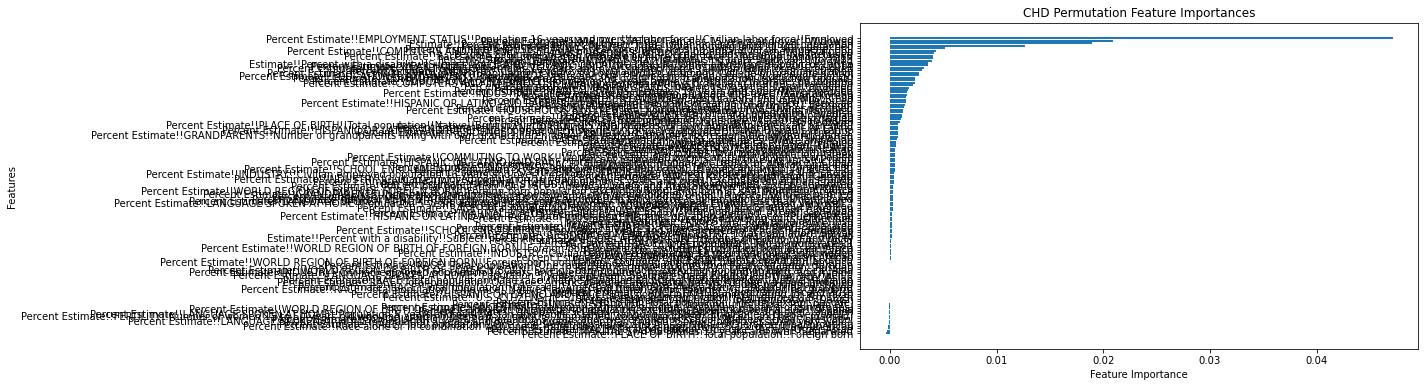

In [59]:
feature_importances = np.mean([fi.importances_mean for fi in feature_importances_all], axis=0)
feature_importances_index = feature_importances.argsort()

least_important = []

distinct_importances = list(set(abs(feature_importances)))

remove_value = 0

# while (len(least_important) < feature_count*0.25 and (feature_count - len(least_important)) > 25) or len(least_important) == 0:
#   for i in feature_importances_index:
#       if abs(feature_importances.importances_mean[i]) == remove_value:
#           least_important.append(X_numeric.columns[i])
#   if remove_value in distinct_importances:
#     distinct_importances.remove(remove_value)
#   if -remove_value in distinct_importances:
#     distinct_importances.remove(-remove_value)
#   if len(distinct_importances) > 0:
#     remove_value = abs(min(distinct_importances))


# print(f"Outcome: {measure}")
# print(f"Test Score: {np.mean(test_scores)}")
# print(f"Train Score: {np.mean(train_scores)}")
# print("Top Permutation Feature Importances:")
# for i in feature_importances_index:
#   print(f"{X_numeric.columns[i]}: {feature_importances.importances_mean[i]}")

    
  
# break
print(f"Outcome: {measure}")
print("\nFinal Permutation Feature Importances:")
# print(feature_importances.importances_mean)
for i in feature_importances_index:
    print(f"{X_numeric.columns[i]}: {feature_importances[i]}")

sorted_feature_importances = feature_importances[feature_importances_index]
sorted_feature_names = X_numeric.columns[feature_importances_index]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances)
plt.yticks(range(len(sorted_feature_importances)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'{measure} Permutation Feature Importances')
plt.show()

['EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed', 'HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Black or African American alone', 'Race alone or in combination with one or more other races!!Total population!!Black or African American', 'UNITS IN STRUCTURE!!Total housing units!!1-unit, detached', 'PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people', 'VALUE!!Owner-occupied units!!$50,000 to $99,999', "EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree", 'VEHICLES AVAILABLE!!Occupied housing units!!No vehicles available', 'SEX AND AGE!!Total population!!65 years and over', 'HEALTH INSURANCE COVERAGE!!Civilian noninstitutionalized population!!With health insurance coverage!!With public coverage']
['EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed', 'HISPANIC OR LATINO AND RACE!!Total populati

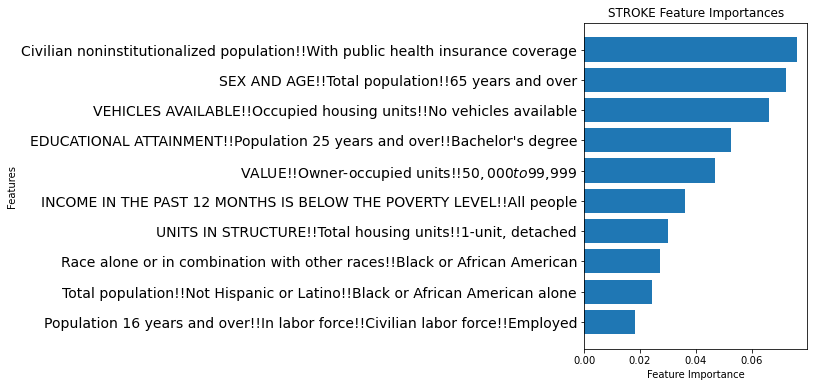

In [37]:
# Plot feature importances
print(sorted_feature_names)
updated_sorted_feature_names = [name.replace("Percent Estimate!!", "").strip() if "Percent Estimate!!" in name else name for name in sorted_feature_names]

print(updated_sorted_feature_names)
updated_sorted_feature_names = ['Population 16 years and over!!In labor force!!Civilian labor force!!Employed', 'Total population!!Not Hispanic or Latino!!Black or African American alone', 'Race alone or in combination with other races!!Black or African American', 'UNITS IN STRUCTURE!!Total housing units!!1-unit, detached', 'INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people', 'VALUE!!Owner-occupied units!!$50,000 to $99,999', "EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree", 'VEHICLES AVAILABLE!!Occupied housing units!!No vehicles available', 'SEX AND AGE!!Total population!!65 years and over', 'Civilian noninstitutionalized population!!With public health insurance coverage']
if measure == 'STROKE':
  plt.figure(figsize=(4, 6))
  plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances)
  plt.yticks(range(len(sorted_feature_importances)), updated_sorted_feature_names, fontsize=14)
  plt.xlabel('Feature Importance')
  plt.ylabel('Features')
  plt.title(f'{measure} Feature Importances')
  plt.show()